In [ ]:

from Models import mobilenetv2, resnet
from Dataloaders import dataloader_cifar10, dataloader_image_20
from Models import gatedmodel
from tqdm import tqdm
import torch
import numpy as np
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as transforms

models_name = {'mobile':mobilenetv2, 'resnet':resnet}
datasets_name = {'cifar':dataloader_cifar10, 'imagenet':dataloader_image_20}
middle_size_mobile = {x:2**x for x in range(5)}
middle_size_resnet = {x:2**x for x in range(6)}
middles_size = {'mobile':middle_size_mobile, 'resnet':middle_size_resnet}

quantization = False
int_trans = False
device = 'cuda:0'

def float_to_uint(x):
    return torch.round(x * 255).int()

def uint_to_float(x):
    return x.float() / 255

def MSE(x, y):
    return torch.mean((x - y)**2)

def KL_div(x, y):
    return torch.mean(x * torch.log(x/y))

def re_transform_cifar(x):
    x = x * torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1) + torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    return x

def re_transform_imagenet(x):
    x = x * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    return x

def transform_cifar(x):
    x = (x - torch.tensor([0.4914, 0.4822, 0.4465]).view(1, 3, 1, 1)) / torch.tensor([0.2023, 0.1994, 0.2010]).view(1, 3, 1, 1)
    return x

def transform_imagenet(x):
    x = (x - torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)) / torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    return x

In [ ]:
width = 16
height = 16
client, server = mobilenetv2.mobilenetv2_splitter(num_classes=10, weight_root='./Weights/cifar-10')

_, test, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1)
_, test2, _ = dataloader_cifar10.Dataloader_cifar10_val(datasetpath='../data/', test_batch=1, normalize=False)

middle_models = []
for i in range (len(middle_size_mobile)):
    middle = mobilenetv2.MobileNetV2_middle(middle=middle_size_mobile[i])
    middle.load_state_dict(torch.load('./Weights/cifar-10/middle/mobile_cifar-10_middle_%s.pth'%str(middle_size_mobile[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)

jpeg_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
middle_results = np.zeros((len(middle_models), len(test.dataset)))
jpeg_results = np.zeros((len(jpeg_list), len(test.dataset)))

stop_ind = 100
with torch.no_grad():
    # get the conf for each middles
    correct_middle = np.zeros(len(middle_models))

    for i, (data, target) in enumerate(tqdm(test)):
        if i == stop_ind:
            break

        original_div = None
        data, target = data.to(device).detach(), target.to(device).detach()
        out = client(data).detach()
        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        original_div = out.clone().detach()

        for j in range(len(middle_models)):
            middle = middle_models[j]
            out = client(data).detach()
            out = middle.in_layer(out)
            out = float_to_uint(out)
            out = uint_to_float(out)
            out = middle.out_layer(out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            middle_results[j, i] = KL_div(out, original_div)
            if torch.argmax(out) == target:
                correct_middle[j] += 1

    correct_jpeg = np.zeros(len(jpeg_list))

    for i, (data, target) in enumerate(tqdm(test2)):
        if i == stop_ind:
            break
        data, target = data, target.to(device).detach()
        out = transform_cifar(data)
        data = data.to(device).detach()
        out = out.to(device)
        out = client(out).detach()
        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        original_div = out.clone().detach()
        for j in range(len(jpeg_list)):
            jpeg = jpeg_list[j]
            out = data.squeeze(0).cpu()
            out = out.permute(1, 2, 0).numpy()
            out = out * 255
            out = out.astype(np.uint8)
            # transform gbr to rgb
            out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
            # store out
            # cv2.imwrite('temp.jpg', out)
            out = cv2.imencode('.jpg', out, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg])[1]
            out = cv2.imdecode(out, cv2.IMREAD_COLOR)
            # transfor rgb to gbr
            # cv2.imwrite('temp%d.jpg'%j, out)
            out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
            out = out.astype(np.float16) / 255
            out = torch.tensor(out).permute(2, 0, 1).unsqueeze(0)
            out = transform_cifar(out).to(device)
            out = client(out).detach()
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            # print if the original_div == out max
            # print(torch.argmax(original_div) == torch.argmax(out))
            jpeg_results[j, i] = KL_div(out, original_div)
            if torch.argmax(out) == target:
                correct_jpeg[j] += 1

middle_pd = pd.DataFrame(middle_results.T, columns=['%d%%'%(middle_size_mobile[x]*100//32) for x in range(len(middle_size_mobile))])
jpeg_pd = pd.DataFrame(jpeg_results.T, columns=[jpeg_list[x] for x in range(len(jpeg_list))])
correct_jpeg = 1 - correct_jpeg / stop_ind
correct_middle = 1 - correct_middle / stop_ind 

plt.figure(figsize=(5, 5))
sns.boxplot(data=middle_pd, palette='Set3')
plt.xlabel('Representation Percentage', fontsize=12)
plt.ylabel('KL Divergence', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2 = plt.twinx()
temp_x = ['3%', '6%', '12%', '25%', '50%']
ax2.plot(temp_x, correct_middle, color='r', label='AVG MR', linewidth=2)
ax2.set_ylabel('Misclassification Rate', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(False)
plt.legend()
plt.savefig('./Plots/middle_boxplot_cifar.pdf', bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(5, 5))
sns.boxplot(data=jpeg_pd, palette='Set3')
plt.xlabel('JPEG Quality', fontsize=12)
plt.ylabel('KL Divergence', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2 = plt.twinx()
temp_x = ['10', '20', '30', '40', '50', '60', '70', '80', '90']
ax2.plot(temp_x, correct_jpeg, label='JPEG')
ax2.set_ylabel('Misclassification Rate', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(False)
plt.savefig('./Plots/jpeg_boxplot_cifar.pdf', bbox_inches='tight')
plt.show()
plt.close()


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


  1%|          | 100/10000 [00:03<05:43, 28.81it/s]


  2%|▏         | 100/5087 [00:12<10:42,  7.76it/s]


AttributeError: Line2D.set() got an unexpected keyword argument 'width'

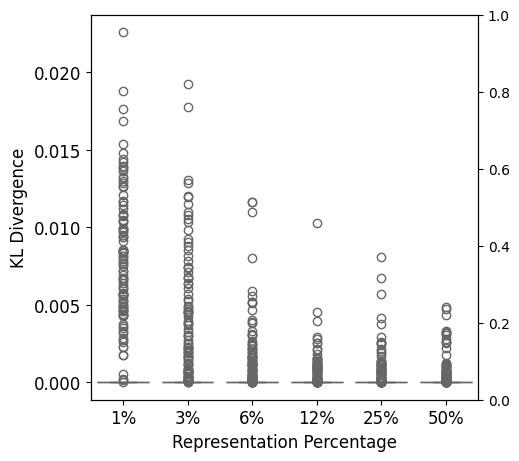

In [8]:
width = 16
height = 16
client, server = resnet.resnet_splitter(num_classes=1000, weight_root='./Weights/imagenet', layers=50)

_, test, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1)
_, test2, _ = dataloader_image_20.Dataloader_imagenet_20_integrated(test_batch=1, transform=False)

middle_models = []
for i in range (len(middle_size_resnet)):
    middle = resnet.resnet_middle(middle=middle_size_resnet[i])
    middle.load_state_dict(torch.load('./Weights/imagenet/middle/resnet_imagenet_middle_%s.pth'%str(middle_size_resnet[i])))
    middle_models.append(middle)

# eval and cuda
client = client.eval().to(device)
server = server.eval().to(device)
for middle in middle_models:
    middle = middle.eval().to(device)

# use the quantization
client = torch.ao.quantization.quantize_dynamic(client, dtype=torch.qint8)
for middle in middle_models:
    middle.in_layer = torch.ao.quantization.quantize_dynamic(middle.in_layer, dtype=torch.qint8)

jpeg_list = [10, 20, 30, 40, 50, 60, 70, 80, 90]
middle_results = np.zeros((len(middle_models), len(test.dataset)))
jpeg_results = np.zeros((len(jpeg_list), len(test.dataset)))

stop_ind = 100
with torch.no_grad():
    # get the conf for each middles
    correct_middle = np.zeros(len(middle_models))

    for i, (data, target) in enumerate(tqdm(test)):
        if i == stop_ind:
            break

        original_div = None
        data, target = data.to(device).detach(), target.to(device).detach()
        out = client(data).detach()
        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        original_div = out.clone().detach()

        for j in range(len(middle_models)):
            middle = middle_models[j]
            out = client(data).detach()
            out = middle.in_layer(out)
            out = float_to_uint(out)
            out = uint_to_float(out)
            out = middle.out_layer(out)
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            middle_results[j, i] = KL_div(out, original_div)
            if torch.argmax(out) == target:
                correct_middle[j] += 1

    correct_jpeg = np.zeros(len(jpeg_list))

    for i, (data, target) in enumerate(tqdm(test2)):
        if i == stop_ind:
            break
        data, target = data, target.to(device).detach()
        out = transform_cifar(data)
        data = data.to(device).detach()
        out = out.to(device)
        out = client(out).detach()
        out = server(out)
        out = torch.nn.functional.softmax(out, dim=1)
        original_div = out.clone().detach()
        for j in range(len(jpeg_list)):
            jpeg = jpeg_list[j]
            out = data.squeeze(0).cpu()
            out = out.permute(1, 2, 0).numpy()
            out = out * 255
            out = out.astype(np.uint8)
            # transform gbr to rgb
            out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
            # store out
            # cv2.imwrite('temp.jpg', out)
            out = cv2.imencode('.jpg', out, [int(cv2.IMWRITE_JPEG_QUALITY), jpeg])[1]
            out = cv2.imdecode(out, cv2.IMREAD_COLOR)
            # transfor rgb to gbr
            # cv2.imwrite('temp%d.jpg'%j, out)
            out = cv2.cvtColor(out, cv2.COLOR_RGB2BGR)
            out = out.astype(np.float16) / 255
            out = torch.tensor(out).permute(2, 0, 1).unsqueeze(0)
            out = transform_cifar(out).to(device)
            out = client(out).detach()
            out = server(out)
            out = torch.nn.functional.softmax(out, dim=1)
            # print if the original_div == out max
            # print(torch.argmax(original_div) == torch.argmax(out))
            jpeg_results[j, i] = KL_div(out, original_div)
            if torch.argmax(out) == target:
                correct_jpeg[j] += 1

middle_pd = pd.DataFrame(middle_results.T, columns=['%d%%'%(middle_size_resnet[x]*100//64) for x in range(len(middle_size_resnet))])
jpeg_pd = pd.DataFrame(jpeg_results.T, columns=[jpeg_list[x] for x in range(len(jpeg_list))])
correct_jpeg = 1 - correct_jpeg / stop_ind
correct_middle = 1 - correct_middle / stop_ind 

plt.figure(figsize=(5, 5))
sns.boxplot(data=middle_pd, palette='Set3')
plt.xlabel('Representation Percentage', fontsize=12)
plt.ylabel('KL Divergence', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# sns.set_theme(style="white", palette=None )
ax2 = plt.twinx()
temp_x = ['1%', '3%', '6%', '12%', '25%', '50%']
ax2.plot(temp_x, correct_middle, label='Middle', width=0.5, legend='AVG MR')
ax2.set_ylabel('Misclassification Rate', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(False)
plt.legend()
plt.savefig('./Plots/middle_boxplot_imagenet.pdf', bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(5, 5))
sns.boxplot(data=jpeg_pd, palette='Set3')
plt.xlabel('JPEG Quality', fontsize=12)
plt.ylabel('KL Divergence', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax2 = plt.twinx()
temp_x = ['10', '20', '30', '40', '50', '60', '70', '80', '90']
ax2.plot(temp_x, correct_jpeg, label='JPEG')
ax2.set_ylabel('Misclassification Rate', fontsize=12)
ax2.set_ylim(0, 1)
ax2.grid(False)
plt.savefig('./Plots/jpeg_boxplot_imagenet.pdf', bbox_inches='tight')
plt.show()
plt.close()
